## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

## Drive Synchronization

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

def sync_drive(forward=True):
    if forward:
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/models" "/content"
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/dataloaders" "/content"
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/experiments" "/content"
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/utils" "/content"
    else:
        !cp -r "/content/checkpoints" "/content/drive/MyDrive/mvp-semantic-mask-refinement"


Mounted at /content/drive


In [3]:
sync_drive(True)

^C


## Configuration

In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
KEEP_NAMES = ["person"]
CLASSES = len(KEEP_NAMES) + 1
NUM_WORKERS = 2
PIN_MEMORY = torch.cuda.is_available()
BATCH_SIZE = 64

DATASET_NAME = "coco-mini-sam-dataset"
MODEL_RESULTS_DIR = os.path.join("checkpoints", 'coco-dataset')
DATA_DIR = os.path.join("./data", DATASET_NAME)

os.makedirs(MODEL_RESULTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

## Coco Dataset

### Download annotations

In [5]:
from pathlib import Path
from pycocotools.coco import COCO

IMG_DIR = f"{DATA_DIR}/images"
MASK_DIR = f"{DATA_DIR}/masks"
ANN_FILE = f"{DATA_DIR}/annotations/instances_train2017.json"

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)

# Download annotations (train+val) – contains instances_val2017.json
ann_zip = os.path.join(DATA_DIR, "annotations_trainval2017.zip")
if not os.path.exists(os.path.join(DATA_DIR, "annotations")):
    !wget -O "{ann_zip}" http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip -q "{ann_zip}" -d "{DATA_DIR}"
    !rm "{ann_zip}"

coco = COCO(ANN_FILE)
print("Contents of /content/coco2017:", os.listdir(DATA_DIR))

--2025-12-04 18:39:20--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.71.105, 52.216.49.129, 52.216.212.185, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.71.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘./data/coco-mini-sam-dataset/annotations_trainval2017.zip’

./data/coco-mini-sa 100%[===================>] 241.19M  18.0MB/s    in 15s     

2025-12-04 18:39:35 (15.8 MB/s) - ‘./data/coco-mini-sam-dataset/annotations_trainval2017.zip’ saved [252907541/252907541]

loading annotations into memory...
Done (t=11.92s)
creating index...
index created!
Contents of /content/coco2017: ['images', 'masks', 'annotations']


### Filter to target classes

In [6]:
CLASS_MAP = {}
class_idx = 1
for name in KEEP_NAMES:
    cat_ids = coco.getCatIds(catNms=[name])
    if len(cat_ids) == 0:
        print(f"[WARN] No COCO category found for '{name}'")
        continue
    # Usually there is exactly one cat_id per name
    for cid in cat_ids:
        CLASS_MAP[cid] = class_idx
    class_idx += 1

pet_cat_ids = list(CLASS_MAP.keys())
NUM_CLASSES = class_idx  # includes background index 0

print("CLASS_MAP (coco_id -> class_idx):", CLASS_MAP)
print("Num classes including background:", NUM_CLASSES)

# ----------------------------------------------------------
# 2. Get union of image ids containing ANY of these classes
# ----------------------------------------------------------
target_img_ids = set()
for cid in pet_cat_ids:
    ids = coco.getImgIds(catIds=[cid])
    print(f"Category {cid} appears in {len(ids)} images")
    target_img_ids.update(ids)

print("Unique images with any of KEEP_NAMES:", len(target_img_ids))

# ----------------------------------------------------------
# 3. Build mapping: file_name -> img_id (only for our target set)
# ----------------------------------------------------------
filename_to_id = {}
for img_id in target_img_ids:
    info = coco.loadImgs(img_id)[0]
    filename_to_id[info["file_name"]] = img_id

print("Filename→ID entries:", len(filename_to_id))

CLASS_MAP (coco_id -> class_idx): {1: 1}
Num classes including background: 2
Category 1 appears in 64115 images
Unique images with any of KEEP_NAMES: 64115
Filename→ID entries: 64115


### Download images

In [7]:
import requests
from tqdm import tqdm
import os
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import random

imgs = random.choices(coco.loadImgs(list(target_img_ids)), k=300)
print("Number of images to download:", len(imgs))


IMG_DIR = Path(IMG_DIR)  # make sure IMG_DIR is a Path
IMG_DIR.mkdir(parents=True, exist_ok=True)

def download_one(img_info):
    url = img_info["coco_url"]
    filename = img_info["file_name"]
    out_path = IMG_DIR / filename

    if out_path.exists():
        # already downloaded
        return filename, True, None

    try:
        r = requests.get(url, stream=True, timeout=10)
        r.raise_for_status()
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(1024):
                if chunk:
                    f.write(chunk)
        return filename, True, None
    except Exception as e:
        return filename, False, str(e)

max_workers = 50  # 8–16 is usually a good balance

futures = []
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    for img_info in imgs:
        futures.append(executor.submit(download_one, img_info))

    for f in tqdm(as_completed(futures),
                  total=len(futures),
                  desc=f"Downloading COCO images ({len(KEEP_NAMES)} classes)"):
        filename, ok, err = f.result()
        # if not ok:
        #     print("Failed:", filename, err)

# count only jpg/jpeg files
downloaded = [
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith(".jpg") or f.lower().endswith(".jpeg")
]
print("Images actually downloaded:", len(downloaded))
print("Downloaded to:", IMG_DIR)

Number of images to download: 300


Images actually downloaded: 300
Downloaded to: data/coco-mini-sam-dataset/images


### Generate masks

In [8]:
from pathlib import Path
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

IMG_DIR = Path(IMG_DIR)        # your existing image dir
MASK_DIR = Path(MASK_DIR)      # your output mask dir
MASK_DIR.mkdir(parents=True, exist_ok=True)

img_files = sorted([f for f in os.listdir(IMG_DIR)
                    if f.lower().endswith(".jpg") or f.lower().endswith(".jpeg")])
print("Found", len(img_files), "image files in IMG_DIR")

def create_mask_for_image(fname):
    """
    Generates and saves a multi-class mask for a single image.
    Returns (True, None) on success, (False, error_message) on failure.
    """
    if fname not in filename_to_id:
        return False, f"Filename {fname} not in filename_to_id (no relevant annotations)"

    img_id = filename_to_id[fname]
    img_info = coco.loadImgs(img_id)[0]
    h, w = img_info["height"], img_info["width"]

    # start with background
    mask = np.zeros((h, w), dtype=np.uint8)

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=pet_cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    if len(anns) == 0:
        return False, f"No annotations found for image {fname}"

    for ann in anns:
        cid = ann["category_id"]
        class_idx = CLASS_MAP.get(cid, 0)   # 0 if somehow not in our map
        if class_idx == 0:
            continue
        ann_mask = coco.annToMask(ann)      # 0/1
        mask[ann_mask == 1] = class_idx     # overwrite is fine for overlaps

    out_path = MASK_DIR / (Path(fname).stem + ".png")
    Image.fromarray(mask).save(out_path)
    return True, None

# ThreadPoolExecutor for parallel processing
max_workers = 8
kept = 0
failed_masks = []

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(create_mask_for_image, fname) for fname in img_files]

    for future in tqdm(as_completed(futures),
                      total=len(futures),
                      desc="Creating multi-class masks"):
        success, msg = future.result()
        if success:
            kept += 1
        else:
            failed_masks.append(msg)

print(f"\nMulti-class masks saved: {kept}")
print(f"Masks directory: {MASK_DIR}")
if failed_masks:
    print(f"Failed to create masks for {len(failed_masks)} images. Examples: {failed_masks[:5]}")


Found 300 image files in IMG_DIR


Creating multi-class masks: 100%|██████████| 300/300 [00:00<00:00, 478.12it/s]


Multi-class masks saved: 300
Masks directory: data/coco-mini-sam-dataset/masks


### Train-Val-Test-Split

In [9]:
from dataloaders.coco_dataset import COCODataset, coco_image_transform, coco_map_transform, MEAN_RGB, STDDEV_RGB

full_coco = COCODataset(
    root=DATA_DIR,
    train=True,
    image_transform=coco_image_transform,
    map_transform=coco_map_transform,
    train_split=1.0,                 # use 100% of images
)

N = len(full_coco)
train_frac = 0.7
val_frac   = 0.15
test_frac  = 0.15

n_train = int(N * train_frac)
n_val   = int(N * val_frac)
n_test  = N - n_train - n_val        # ensures all samples used

generator = torch.Generator().manual_seed(42)
train_set, val_set, test_set = random_split(
    full_coco,
    [n_train, n_val, n_test],
    generator=generator
)

print(f"Total: {N}, Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

# 2) DataLoaders
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)


Train set: 300 images
Total: 300, Train: 210, Val: 45, Test: 45


## Initializing Sam

In [10]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-x3tz_3ap
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-x3tz_3ap
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5c544409bca5544e8e19db61133384cbfd909cd57a5c851db697594174fc3e1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xvmymxo6/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [20]:
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

HOME: /content


In [21]:
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Load baseline U-Net

In [13]:
sync_drive(True)

In [18]:
from models.unet import UNet   # adjust import to your project

# Path to your best baseline checkpoint
BASELINE_CKPT = os.path.join(MODEL_RESULTS_DIR, "unet_best.pt")  # adjust if needed

baseline_model = UNet(in_channels=3, num_classes=2).to(DEVICE)
state = torch.load(BASELINE_CKPT, map_location=DEVICE)
baseline_model.load_state_dict(state["net"])
baseline_model.eval()

print("Loaded baseline U-Net from:", BASELINE_CKPT)

Loaded baseline U-Net from: checkpoints/coco-dataset/unet_best.pt


## Comparison on a few test images


Per-example IoU / Boundary-F1 (person class):
Example 0: IoU U-Net=0.491, SAM=0.915 | BF1 U-Net=0.217, SAM=0.746
Example 1: IoU U-Net=0.559, SAM=0.927 | BF1 U-Net=0.335, SAM=0.808
Example 2: IoU U-Net=0.059, SAM=0.373 | BF1 U-Net=0.093, SAM=0.519
Example 3: IoU U-Net=0.288, SAM=0.438 | BF1 U-Net=0.269, SAM=0.535
Example 4: IoU U-Net=0.442, SAM=0.948 | BF1 U-Net=0.188, SAM=0.844
Example 5: IoU U-Net=0.252, SAM=0.857 | BF1 U-Net=0.235, SAM=0.922
Example 6: IoU U-Net=0.642, SAM=0.513 | BF1 U-Net=0.423, SAM=0.454
Example 7: IoU U-Net=0.120, SAM=0.153 | BF1 U-Net=0.267, SAM=0.242


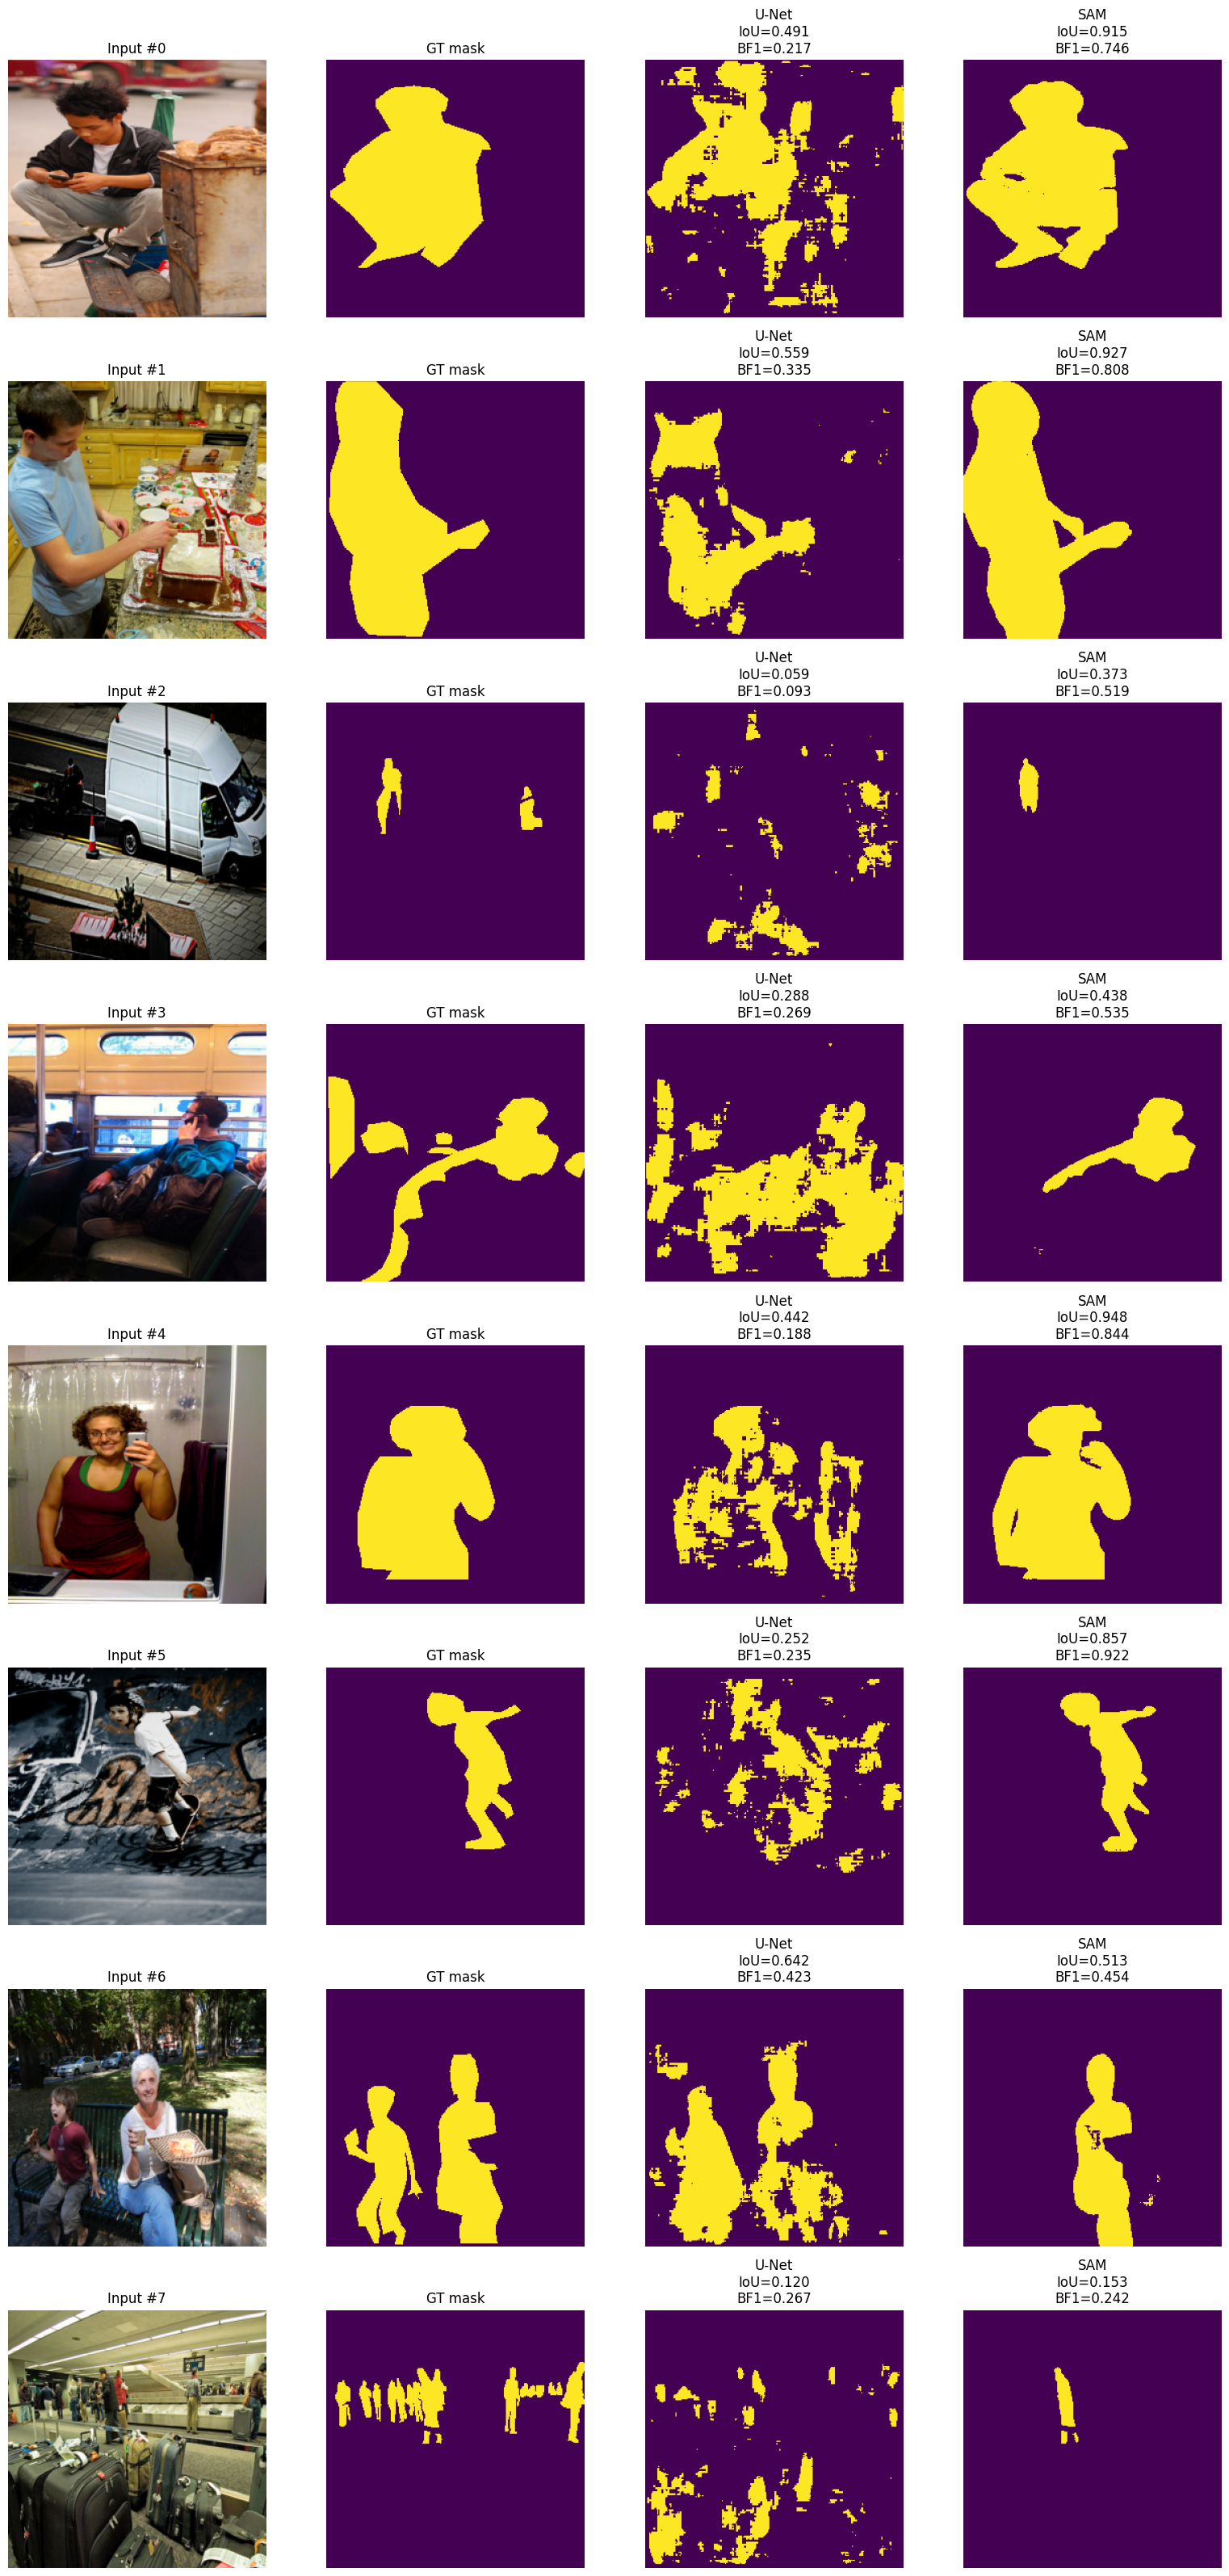

In [27]:
from experiments.sam_compare import (
    build_mask_generator,
    visualize_unet_vs_sam_subset,
)

mask_generator = build_mask_generator(sam)

visualize_unet_vs_sam_subset(
    unet_model=baseline_model,
    mask_generator=mask_generator,
    loader=test_loader,
    device=DEVICE,
    mean_rgb=MEAN_RGB,
    std_rgb=STDDEV_RGB,
    num_classes=CLASSES,
    person_label=1,
    max_examples=8,
)